In [1]:
import scipy.io
import numpy as np
import networkx as nx
import os
import pandas as pd
from sklearn.cluster import SpectralClustering
# import community  # Install using: pip install python-louvain
import matplotlib.pyplot as plt
import re

In [2]:
excel_file = 'fungal_networks_data/list_of_fungal_networks.xlsx'
fnd_df = pd.read_excel(excel_file, index_col='code')

filename = 'Pp_M_Tokyo_U_N_26h_1.txt'
substrate = fnd_df['substrate']
fnd_df

/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,species,size,resources,grazing,interaction,time point,repeat,include,substrate,-K2,comments,citation
code,,,,,,,,,,,,
Pp_M_Tokyo_U_N_26h_1,Pp,M,Tokyo,U,N,26h,1,Y,A,-k2,NaN,"Tero, A., Takagi, S., Saigusa, T., Ito, K., Be..."
Pp_M_Tokyo_U_N_26h_2,Pp,M,Tokyo,U,N,26h,2,Y,A,-k2,NaN,"Tero, A., Takagi, S., Saigusa, T., Ito, K., Be..."
Pp_M_Tokyo_U_N_26h_3,Pp,M,Tokyo,U,N,26h,3,NaN,A,full,NaN,"Tero, A., Takagi, S., Saigusa, T., Ito, K., Be..."
Pp_M_Tokyo_U_N_26h_4,Pp,M,Tokyo,U,N,26h,4,Y,A,-k2,NaN,"Tero, A., Takagi, S., Saigusa, T., Ito, K., Be..."
Pp_M_Tokyo_U_N_26h_5,Pp,M,Tokyo,U,N,26h,5,NaN,A,full,NaN,"Tero, A., Takagi, S., Saigusa, T., Ito, K., Be..."
...,...,...,...,...,...,...,...,...,...,...,...,...
Pv_M_I_U_Hf_18d_3,Pv,M,I,U,Hf,18d,3,Y,S,-k2,NaN,"Rotheray, T.D., Jones, T.H., Fricker, M.D. and..."
Pv_M_I_U_Hf_22d_3,Pv,M,I,U,Hf,22d,3,Y,S,-k2,NaN,"Rotheray, T.D., Jones, T.H., Fricker, M.D. and..."
Pv_M_I_U_Hf_26d_3,Pv,M,I,U,Hf,26d,3,Y,S,-k2,NaN,"Rotheray, T.D., Jones, T.H., Fricker, M.D. and..."


In [3]:
class TreeNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        
color_dict = {
    'A': 'blue',
    'B': 'red',
    'S': 'green',
}

node1 = TreeNode('Pp_M_Tokyo_U_N_26h_1.txt')
color_dict[fnd_df.at[node1.value[:-4], 'substrate']]

'blue'

In [4]:
##########################################################################################
#                                    ALL FUNCTIONS
##########################################################################################

def get_graph_from_file(file, flag):
    if flag:
        print(f'Reading the network file: {file}\n')
    
    return nx.read_weighted_edgelist(file, nodetype=str)


def graph_properties(G, flag, file):
    '''
    Parameters:
        G (graph)
        flag (int): flag=1 to print graph stats, 0 else
    '''
    
    n = len(G.nodes())
    m = len(G.edges())
    C = nx.transitivity(G)
    degrees = nx.degree(G)
    kis = [k for _,k in degrees]
    kstd = np.std(kis)
    kmean = np.mean(kis)
    max_edges = n * (n - 1) / 2
    edge_density = m / max_edges
    if nx.is_connected(G):
        average_shortest_path_length = nx.average_shortest_path_length(G, weight='weight')
    else :
        average_shortest_path_length = 0
    
    betweenness = nx.betweenness_centrality(G, weight='weight')
    non_zero_betweenness = [value for value in betweenness.values() if value != 0]
    avg_betweenness_centrality = np.mean(non_zero_betweenness)

    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    average_edge_weight = total_weight / G.number_of_edges()

    if flag:
        print("Number of nodes (n):", n)
        print("Number of edges (m):", m)
        print("Clustering Coefficient (C):", C)
        print("Mean Degree (kmean):", kmean)
        print("Degree STD (kstd):", kstd)
        print("Edge density (D):", edge_density)
        print("Average shortest path length: ", average_shortest_path_length)
        print("Average betweeness centrality: ", avg_betweenness_centrality)
        print("Average edge weight: ", average_edge_weight)
        print("\n")
        
    return [C,kstd,kmean,edge_density,average_shortest_path_length,
            avg_betweenness_centrality,average_edge_weight, file]


def get_all_vectors(directory, flag):
    '''
    Parameters:
        directory path (string)
        flag (int): flag=1 to print graph stats, 0 else
    '''
    files = os.listdir(directory)  # Slicing should be done after calling listdir()
    all_graphs = []
    all_graphs_properties = []
    
    flag_count = 0
    files = list(set(files))
    
    for file in files:
        file_pathway = directory+file
        if flag_count >= 5:
            flag = 0
            # break
        
        if os.path.isfile(file_pathway):
            G = get_graph_from_file(file_pathway, flag) 
            p = graph_properties(G, flag, file)
            all_graphs.append(G)
            all_graphs_properties.append(p)
            flag_count += 1
        
    return all_graphs_properties

def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))


def lower_distance_matrix(df):
    """
    Calculate the lower half of the distance matrix for vectors stored in a DataFrame using Euclidean
    
    Args:
        df (pandas.DataFrame): DataFrame containing vectors as rows.
        
    Returns:
        pandas.DataFrame: Lower half of the distance matrix.
    """
    
    num_rows = df.shape[0]
    distance_matrix = np.zeros((num_rows, num_rows))
    
    # Calculate pairwise distances
    for i in range(num_rows):
        for j in range(i):
            distance_matrix[i, j] = euclidean_distance(df.iloc[i], df.iloc[j])
    
    # Convert to DataFrame with filename as index
    distance_df = pd.DataFrame(distance_matrix, index=df.index, columns=df.index)
    
    return distance_df


In [5]:
# A Quick Implementation of UPGMA (Unweighted Pair Group Method with Arithmetic Mean)

# lowest_cell:
#   Locates the smallest cell in the table
def lowest_cell(table):
    # Set default to infinity
    min_cell = float("inf")
    x, y = -1, -1

    # Go through every cell, looking for the lowest
    for i in range(len(table)):
        for j in range(len(table[i])):
            if table[i][j] < min_cell:
                min_cell = table[i][j]
                x, y = i, j

    # Return the x, y co-ordinate of cell
    return x, y


# join_labels:
#   Combines two labels in a list of labels
def join_labels(labels, a, b):
    # Swap if the indices are not ordered
    if b < a:
        a, b = b, a

    # Join the labels in the first index
    labels[a] = [labels[a],labels[b]]

    # Remove the (now redundant) label in the second index
    del labels[b]
    
def join_labels(labels, a, b):
    # Swap if the indices are not ordered
    if b < a:
        a, b = b, a

    # Join the labels in the first index
    labels[a] = [labels[a],labels[b]]

    # Remove the (now redundant) label in the second index
    del labels[b]



# join_table:
#   Joins the entries of a table on the cell (a, b) by averaging their data entries
def join_table(table, a, b):
    # Swap if the indices are not ordered
    if b < a:
        a, b = b, a

    # For the lower index, reconstruct the entire row (A, i), where i < A
    row = []
    for i in range(0, a):
        row.append((table[a][i] + table[b][i])/2)
    table[a] = row
    
    # Then, reconstruct the entire column (i, A), where i > A
    #   Note: Since the matrix is lower triangular, row b only contains values for indices < b
    for i in range(a+1, b):
        table[i][a] = (table[i][a]+table[b][i])/2
        
    #   We get the rest of the values from row i
    for i in range(b+1, len(table)):
        table[i][a] = (table[i][a]+table[i][b])/2
        # Remove the (now redundant) second index column entry
        del table[i][b]

    # Remove the (now redundant) second index row
    del table[b]


# UPGMA:
#   Runs the UPGMA algorithm on a labelled table
def UPGMA(table, labels):
    # Until all labels have been joined...
    while len(labels) > 1:
        # Locate lowest cell in the table
        x, y = lowest_cell(table)

        # Join the table on the cell co-ordinates
        join_table(table, x, y)

        # Update the labels accordingly
        join_labels(labels, x, y)

    # Return the final label
    return labels[0]


## A test using an example calculation from http://www.nmsr.org/upgma.htm

# alpha_labels:
#   Makes labels from a starting letter to an ending letter
def alpha_labels(start, end):
    labels = []
    for i in range(ord(start), ord(end)+1):
        labels.append(i)
    return labels

def lower_distance_to_M_data(lower_distance_df):
    """
    Convert lower distance DataFrame to M_data format for UPGMA.
    
    Args:
        lower_distance_df (pandas.DataFrame): Lower half of the distance matrix.
        
    Returns:
        list: M_data list for UPGMA.
    """
    M_data = []
    num_rows = lower_distance_df.shape[0]
    for i in range(num_rows):
        row_data = []
        for j in range(i):
            row_data.append(lower_distance_df.iloc[i, j])
        M_data.append(row_data)
    return M_data

class TreeNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None

def list_to_binary_tree(lst):
    if isinstance(lst, str):
        return TreeNode(lst)
    
    root = TreeNode(None)
    root.left = list_to_binary_tree(lst[0])
    
    if len(lst) == 2:
        root.right = list_to_binary_tree(lst[1])
    
    return root


def get_node_color(node):
    if node.value is not None:
        print(node.value[:-4])
        return color_dict[fnd_df.at[node.value[:-4], 'substrate']]
    else:
        return 'black'
        
def plot_tree(node, x, y, spacing, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    if node is not None:
        ax.plot(x, y, 'o', markersize=12, color='black')  # Plot node
        ax.text(x, y, str(node.value), verticalalignment='center', horizontalalignment='center')  # Add node value as text
        if node.left is not None:
            ax.plot([x, x - spacing], [y, y - 1], '-k')  # Plot left edge
            plot_tree(node.left, x - spacing, y - 1, spacing / 2, ax)  # Recursively plot left subtree
        if node.right is not None:
            ax.plot([x, x + spacing], [y, y - 1], '-k')  # Plot right edge
            plot_tree(node.right, x + spacing, y - 1, spacing / 2, ax)  # Recursively plot right subtree

def replace_with_ln(x):
    if not isinstance(x, str):
        if x > 10:
            return np.log(x)
        return x
    else:
        return x


In [5]:
####### Helpers for clustering #######

# def louvain_clustering(G, flag):
#     partition = community.best_partition(G)
#     num_clusters = len(set(partition.values())) # Count the number of unique community IDs\

#     if flag:
#         # Draw the graph with nodes colored by community
#         pos = nx.spring_layout(G)  # Positions for all nodes
#         plt.figure(figsize=(8, 6))

#         # Draw nodes, coloring them by community
#         node_colors = [partition[n] for n in G.nodes()]
#         nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=20)

#         plt.title("Graph with Nodes Colored by Community (Louvain Method)")
#         plt.show()
        
#     return partition, num_clusters

In [6]:
# G = nx.karate_club_graph

In [7]:
# fname1 = 'fungal_networks_data/Conductance_Text_Files/Sc_M_I_U_N_42d_1.txt'
# G = get_graph_from_file(fname1, fname1)

In [8]:
#########    TEST HELPER FUNCTIONS FOR ONE FILE    #########

# partition, num_clusters = louvain_clustering(G, 1)
# graph_properties(G, 1, fname1)
# print(f'Number of clusters = {num_clusters}')

In [ ]:
####################################################################################
####################################################################################
####################################################################################
####################################################################################
########################            CONDUCTANCE            #########################
####################################################################################
####################################################################################
####################################################################################
####################################################################################

In [68]:
##################     GET ALL GRAPHS AND PROPERTIES     ##################
flag = 0
directory = 'fungal_networks_data/Conductance_Text_Files/'
# gmatrix = get_all_vectors(directory, flag)
gmatrix = pd.read_csv('vectors.csv')
column_names = ['C', 'kstd', 'kmean', 'edge_density','average_shortest_path_length','avg_betweenness_centrality','average_edge_weight','file']
df = pd.DataFrame(gmatrix, columns=column_names)
df.set_index('file', inplace=True)

df

,C,kstd,kmean,edge_density,average_shortest_path_length,avg_betweenness_centrality,average_edge_weight
file,,,,,,,
Rb_M_I_Fc-H_N_20d_1.txt,0.079430,1.627588,2.256983,0.012680,0.000000,0.072076,4255.600195
Pv_M_I+4R_U_N_39d_3.txt,0.061126,1.249432,2.233796,0.002588,0.007653,0.027278,0.000411
Rb_M_I_U_N_18d_2.txt,0.069333,1.999792,2.423841,0.008053,22159.387399,0.056738,3140.542753
Pv_L_I+4xR_U_N_57d_1.txt,0.074269,0.996752,2.641404,0.001855,0.000000,0.029337,0.006161
Pv_M_I_U_N_31d_1.txt,0.041149,1.175326,2.202294,0.001149,0.016257,0.026421,0.000415
...,...,...,...,...,...,...,...
Pv_M_I_U_Hf_22d_2.txt,0.078322,1.431390,2.581844,0.001847,0.117154,0.027449,0.008630
Pv_M_I+4R_U_N_42d_1.txt,0.052120,1.243313,2.237611,0.001423,0.017854,0.032957,0.000658
Pv_M_I+R_U_N_18d_1.txt,0.115268,1.382307,2.978304,0.005886,0.099048,0.040881,0.017027


In [11]:
df.to_csv('vectors.csv', index=True)

In [75]:
df = pd.read_csv('distances.csv')

# Apply the function to all elements of the DataFrame
df_ln = df.applymap(replace_with_ln)
df_ln.to_csv('distances_ln.csv', index=True)

In [69]:
##################     GET DISTANCE MATRIX     ##################
lower_distance_df = lower_distance_matrix(df)


In [44]:
n = lower_distance_df.shape[0]
symmetric_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1):
        symmetric_matrix[i, j] = lower_distance_df.iloc[i, j]
        symmetric_matrix[j, i] = lower_distance_df.iloc[i, j]

# Convert symmetric matrix to DataFrame
symmetric_distance_df = pd.DataFrame(symmetric_matrix, index=lower_distance_df.index, columns=lower_distance_df.columns)

# Display the symmetric distance DataFrame
symmetric_distance_df

file,Rb_M_I_Fc-H_N_20d_1.txt,Pv_M_I+4R_U_N_39d_3.txt,Rb_M_I_U_N_18d_2.txt,Pv_L_I+4xR_U_N_57d_1.txt,Pv_M_I_U_N_31d_1.txt,Rb_M_I_U_N_26d_3.txt,Pp_M_Tokyo_U_N_26h_1.txt,Pv_M_I+4R_U_N_36d_2.txt,Pv_M_I_U_N_27d_1.txt,Pv_L_I+4xR_U_N_36d_4.txt,...,Pp_M_Tokyo_U_N_26h_11.txt,Pv_M_5xI_U_N_33d_3.txt,Pv_M_I_U_Hf_26d_3.txt,Pv_M_I_Fc_Hf_48d_2.txt,Pv_M_I+4R_U_N_27d_1.txt,Pv_M_I_U_Hf_22d_2.txt,Pv_M_I+4R_U_N_42d_1.txt,Pv_M_I+R_U_N_18d_1.txt,Pv_M_I_U_N_18d_3.txt,Pv_M_5xI_U_N_22d_3.txt
file,,,,,,,,,,,,,,,,,,,,,
Rb_M_I_Fc-H_N_20d_1.txt,0.000000,4255.599801,22187.424438,4255.594098,4255.599805,13109.480470,77439.075233,4255.596544,4255.599854,4255.593781,...,4255.572255,4255.596232,4255.589776,4255.583939,4255.599709,4255.591584,4255.599555,4255.583238,4255.599853,4255.597761
Pv_M_I+4R_U_N_39d_3.txt,4255.599801,0.000000,22380.820306,0.479854,0.083426,13047.500922,77899.735886,0.152118,0.094394,0.283851,...,0.922752,0.456321,0.591240,0.450383,0.043477,0.408167,0.016457,0.764005,0.116198,0.346330
Rb_M_I_U_N_18d_2.txt,22187.424438,22380.820306,0.000000,22380.827086,22380.811789,9334.383427,55519.328401,22380.772713,22380.813432,22380.827038,...,22380.592636,22380.786547,22380.690440,22380.825651,22380.815728,22380.710729,22380.810171,22380.727485,22380.820786,22380.827597
Pv_L_I+4xR_U_N_57d_1.txt,4255.594098,0.479854,22380.827086,0.000000,0.475510,13047.507640,77899.742686,0.344897,0.484274,0.216259,...,0.490105,0.156095,0.542775,0.443469,0.450236,0.454102,0.474019,0.523367,0.526988,0.153059
Pv_M_I_U_N_31d_1.txt,4255.599805,0.083426,22380.811789,0.475510,0.000000,13047.492416,77899.727361,0.175327,0.014589,0.304099,...,0.926128,0.477296,0.653139,0.514954,0.112891,0.470381,0.077687,0.811103,0.060932,0.359771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pv_M_I_U_Hf_22d_2.txt,4255.591584,0.408167,22380.710729,0.454102,0.470381,13047.391406,77899.626277,0.320894,0.483552,0.305944,...,0.724592,0.313506,0.184921,0.132814,0.367124,0.000000,0.405599,0.401932,0.517011,0.331183
Pv_M_I+4R_U_N_42d_1.txt,4255.599555,0.016457,22380.810171,0.474019,0.077687,13047.490797,77899.725745,0.144057,0.089558,0.279597,...,0.915231,0.451338,0.589131,0.450742,0.042652,0.405599,0.000000,0.760839,0.114152,0.341664
Pv_M_I+R_U_N_18d_1.txt,4255.583238,0.764005,22380.727485,0.523367,0.811103,13047.408071,77899.643080,0.639594,0.824218,0.535658,...,0.510405,0.392255,0.269067,0.357774,0.720917,0.401932,0.760839,0.000000,0.863819,0.507343


In [59]:
def func(row):
    index_name = row.name
    return fnd_df.at[index_name[:-4], 'substrate']

# Apply the function to create a new column
symmetric_distance_df['substrate'] = symmetric_distance_df.apply(func, axis=1)
symmetric_distance_df.to_csv('distances_substrate.csv', index_label='index', header=True)

In [50]:
# np.savetxt('distances.csv', symmetric_distance_df, delimiter=',')
# # Assuming df is your DataFrame
# symmetric_distance_df.to_csv('distances.csv', index_label='index', header=True)

In [48]:
import scipy.io
import numpy as np

# Save the distance matrix and row/column names to a .mat file
scipy.io.savemat('distance_matrix.mat', {'distances': symmetric_distance_df, 'row_names': symmetric_distance_df.index.tolist(),
                                         'column_names': symmetric_distance_df.columns.tolist()})


In [13]:
##################     SMALL TEST ON THING       ##################

M_labels = lower_distance_df.index.tolist()
M = lower_distance_to_M_data(lower_distance_df)
lst = UPGMA(M, M_labels)


In [65]:
symmetric_distance_df = symmetric_distance_df.drop(columns=['substrate'])


In [29]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform


# Your distance matrix
distances = pd.read_csv('distances_ln.csv')
# # distances = distances.drop(df.columns[[1]], axis=1)
dist_sub = distances

dist_sub.set_index('index', inplace=True)

unnamed_columns = [col for col in dist_sub.columns if col.startswith('Unnamed')]
dist_sub = dist_sub.drop(columns=unnamed_columns)

dist_sub

,Rb_M_I_Fc-H_N_20d_1.txt,Pv_M_I+4R_U_N_39d_3.txt,Rb_M_I_U_N_18d_2.txt,Pv_L_I+4xR_U_N_57d_1.txt,Pv_M_I_U_N_31d_1.txt,Rb_M_I_U_N_26d_3.txt,Pp_M_Tokyo_U_N_26h_1.txt,Pv_M_I+4R_U_N_36d_2.txt,Pv_M_I_U_N_27d_1.txt,Pv_L_I+4xR_U_N_36d_4.txt,...,Pp_M_Tokyo_U_N_26h_11.txt,Pv_M_5xI_U_N_33d_3.txt,Pv_M_I_U_Hf_26d_3.txt,Pv_M_I_Fc_Hf_48d_2.txt,Pv_M_I+4R_U_N_27d_1.txt,Pv_M_I_U_Hf_22d_2.txt,Pv_M_I+4R_U_N_42d_1.txt,Pv_M_I+R_U_N_18d_1.txt,Pv_M_I_U_N_18d_3.txt,Pv_M_5xI_U_N_22d_3.txt
index,,,,,,,,,,,,,,,,,,,,,
Rb_M_I_Fc-H_N_20d_1.txt,0.000000,8.355991,10.007281,8.355990,8.355991,9.481091,11.257247,8.355990,8.355991,8.355990,...,8.355985,8.355990,8.355989,8.355987,8.355991,8.355989,8.355991,8.355987,8.355991,8.355991
Pv_M_I+4R_U_N_39d_3.txt,8.355991,0.000000,10.015960,0.479854,0.083426,9.476352,11.263178,0.152118,0.094394,0.283851,...,0.922752,0.456321,0.591240,0.450383,0.043477,0.408167,0.016457,0.764005,0.116198,0.346330
Rb_M_I_U_N_18d_2.txt,10.007281,10.015960,0.000000,10.015960,10.015959,9.141460,10.924486,10.015958,10.015959,10.015960,...,10.015949,10.015958,10.015954,10.015960,10.015959,10.015955,10.015959,10.015955,10.015960,10.015960
Pv_L_I+4xR_U_N_57d_1.txt,8.355990,0.479854,10.015960,0.000000,0.475510,9.476352,11.263178,0.344897,0.484274,0.216259,...,0.490105,0.156095,0.542775,0.443469,0.450236,0.454102,0.474019,0.523367,0.526988,0.153059
Pv_M_I_U_N_31d_1.txt,8.355991,0.083426,10.015959,0.475510,0.000000,9.476351,11.263178,0.175327,0.014589,0.304099,...,0.926128,0.477296,0.653139,0.514954,0.112891,0.470381,0.077687,0.811103,0.060932,0.359771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pv_M_I_U_Hf_22d_2.txt,8.355989,0.408167,10.015955,0.454102,0.470381,9.476344,11.263176,0.320894,0.483552,0.305944,...,0.724592,0.313506,0.184921,0.132814,0.367124,0.000000,0.405599,0.401932,0.517011,0.331183
Pv_M_I+4R_U_N_42d_1.txt,8.355991,0.016457,10.015959,0.474019,0.077687,9.476351,11.263178,0.144057,0.089558,0.279597,...,0.915231,0.451338,0.589131,0.450742,0.042652,0.405599,0.000000,0.760839,0.114152,0.341664
Pv_M_I+R_U_N_18d_1.txt,8.355987,0.764005,10.015955,0.523367,0.811103,9.476345,11.263177,0.639594,0.824218,0.535658,...,0.510405,0.392255,0.269067,0.357774,0.720917,0.401932,0.760839,0.000000,0.863819,0.507343


/tmp/ipykernel_375/3232813409.py:32: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tree = linkage(distances, method='average',optimal_ordering=False)  # Use 'average' method for UPGMA


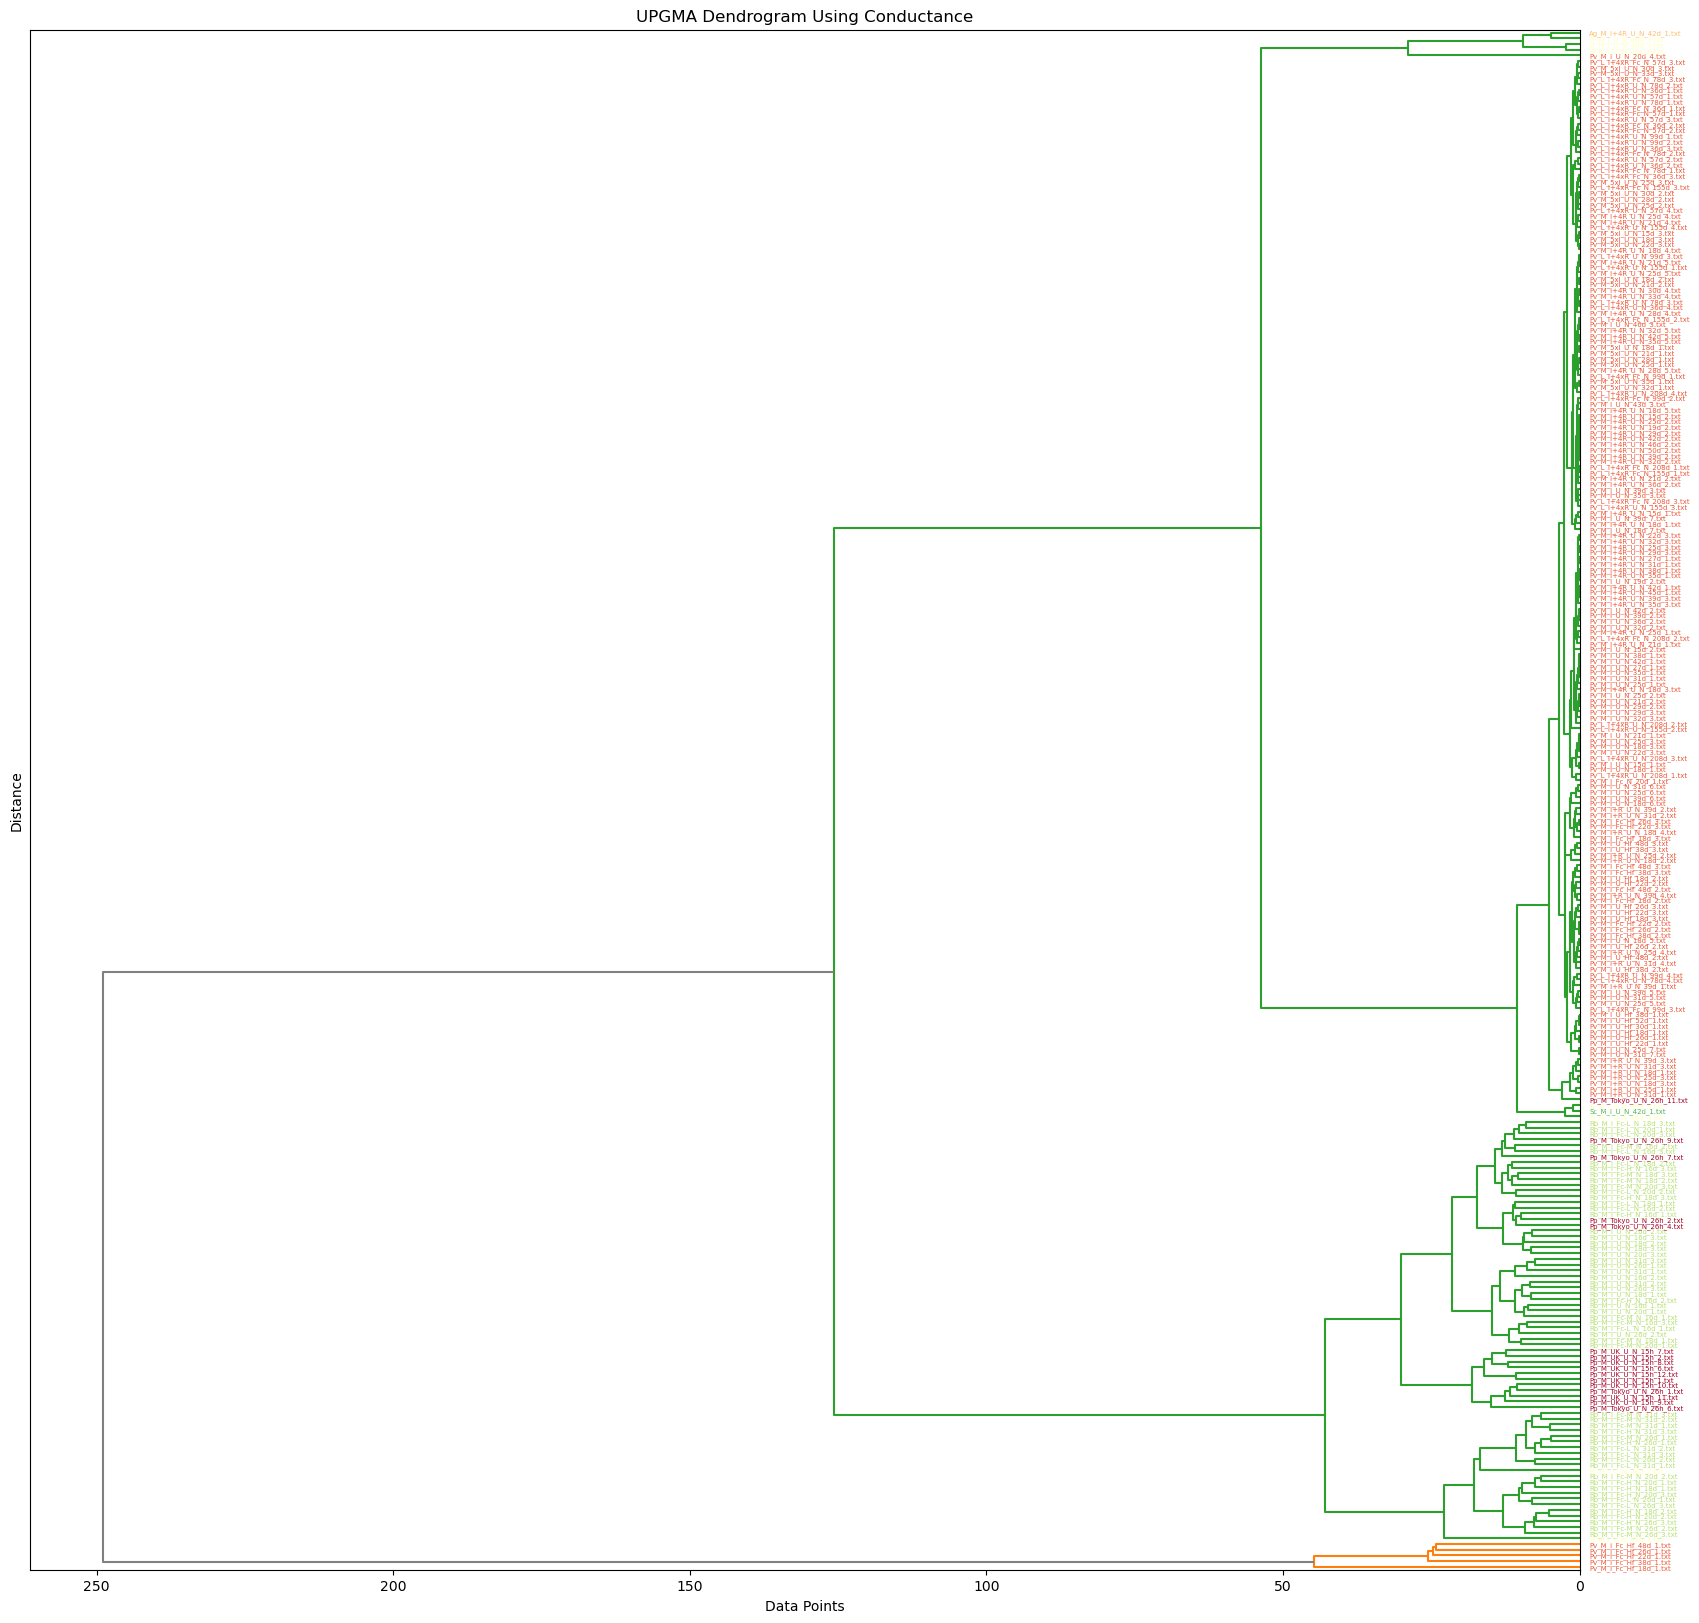

Pp: (0.6470588235294118, 0.0, 0.14901960784313725, 1.0)
Pv: (0.918954248366013, 0.3477124183006535, 0.22614379084967318, 1.0)
Ag: (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
Pi: (1.0, 1.0, 0.7490196078431373, 1.0)
Rb: (0.7176470588235295, 0.8797385620915033, 0.45882352941176474, 1.0)
Sc: (0.3006535947712421, 0.6928104575163401, 0.3633986928104576, 1.0)


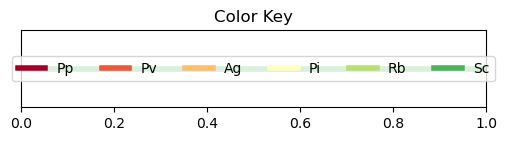

In [116]:
# graph

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

color_mapping = {
    'Pp': 0,
    'Pv': 1,
    'Ag': 2,
    'Pi': 3,
    'Rb': 4,
    'Sc': 5,
    'none': 6
}

def get_leaf_color(filename):
    if filename[-4:] == '.txt':
        value = filename[0:2]
        return color_mapping[value]
    else:
        return color_mapping['none']

# Pass the leaf attributes to the color calculation function
leaf_colors = [get_leaf_color(index_name) for index_name in dist_sub.index]

# distance matrix
distances = pd.read_csv('conductance_distances_ln.csv')
distances.set_index('index', inplace=True)
distances = distances.drop(distances.columns[[0]], axis=1)

tree = linkage(distances, method='average',optimal_ordering=False)  # Use 'average' method for UPGMA

# Plot dendrogram
plt.figure(figsize=(20, 20))
# dendrogram(tree, labels=distances.index, leaf_rotation=90)
dendrogram(tree, labels=distances.index, leaf_rotation=0, orientation="left", color_threshold=240, above_threshold_color='grey')
plt.title('Dendrogram Using Conductance')
plt.xlabel('Data Points')
plt.ylabel('Distance')
# plt.show()


my_palette = plt.cm.get_cmap('RdYlGn', 7)
 
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    val = get_leaf_color(lbl.get_text())
    lbl.set_color(my_palette(val))

# Show the graph
plt.show()

# Define labels for each color
color_labels = ['Pp','Pv','Ag','Pi','Rb','Sc']

# Create a dictionary to map colors to labels
color_map = {my_palette(i): label for i, label in enumerate(color_labels)}

# Display the colors and their corresponding labels
for color, label in color_map.items():
    print(f'{label}: {color}')

# Plot example colors
plt.figure(figsize=(6, 1))
for color, label in color_map.items():
    plt.plot([0, 1], [0, 0], color=color, label=label, linewidth=4)
plt.xlim(0, 1)
plt.ylim(-0.5, 0.5)
plt.yticks([])
plt.legend(loc='center', ncol=len(color_labels))
plt.title('Color Key')
plt.show()


In [78]:
####################################################################################
####################################################################################
####################################################################################
####################################################################################
#########################            PATH SCORE            #########################
####################################################################################
####################################################################################
####################################################################################
####################################################################################

In [81]:
##################     GET ALL GRAPHS AND PROPERTIES     ##################
flag = 0
directory = 'fungal_networks_data/Path_Score_Text_Files/'
# gmatrix = get_all_vectors(directory, flag)
gmatrix = pd.read_csv('path_score_vectors.csv')
column_names = ['C', 'kstd', 'kmean', 'edge_density','average_shortest_path_length','avg_betweenness_centrality','average_edge_weight','file']
psvecs = pd.DataFrame(gmatrix, columns=column_names)
psvecs.set_index('file', inplace=True)

psvecs

,C,kstd,kmean,edge_density,average_shortest_path_length,avg_betweenness_centrality,average_edge_weight
file,,,,,,,
Pv_M_I+4R_U_N_27d_1.txt,0.144913,0.855159,2.785924,0.008194,0.0,0.022698,0.009950
Rb_M_I_Fc-L_N_16d_3.txt,0.136957,1.570601,3.195876,0.033290,0.0,0.053408,0.020824
Pv_M_I+4R_U_N_29d_3.txt,0.180583,0.736542,2.647619,0.012668,0.0,0.035083,0.019230
Pv_M_I_Fc_Hf_38d_2.txt,0.134267,1.056477,2.988372,0.002899,0.0,0.019169,0.003332
Pv_M_I_U_N_15d_1.txt,0.124424,0.581344,2.310078,0.018047,0.0,0.001925,0.027958
...,...,...,...,...,...,...,...
Pv_M_5xI_U_N_21d_2.txt,0.119231,0.766758,2.735043,0.004683,0.0,0.029372,0.008983
Pv_M_I_U_N_18d_6.txt,0.095137,1.262376,2.637500,0.016588,0.0,0.037684,0.025245
Pv_L_I+4xR_U_N_78d_1.txt,0.088156,0.599863,2.758539,0.003253,0.0,0.029216,0.005701


In [80]:
# df.to_csv('path_score_vectors.csv', index=True)

In [88]:
ps_lower_dist = lower_distance_matrix(psvecs)
# ps_lower_dist

In [103]:
###################### MAKE SYMETRICAL ######################
n = ps_lower_dist.shape[0]
ps_symetric_dist = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1):
        ps_symetric_dist[i, j] = ps_lower_dist.iloc[i, j]
        ps_symetric_dist[j, i] = ps_lower_dist.iloc[i, j]

# Convert symmetric matrix to DataFrame
ps_symetric_dist = pd.DataFrame(ps_symetric_dist, index=ps_lower_dist.index, columns=ps_lower_dist.columns)

# Display the symmetric distance DataFrame
ps_symetric_dist

file,Pv_M_I+4R_U_N_27d_1.txt,Rb_M_I_Fc-L_N_16d_3.txt,Pv_M_I+4R_U_N_29d_3.txt,Pv_M_I_Fc_Hf_38d_2.txt,Pv_M_I_U_N_15d_1.txt,Pv_M_I_Fc_Hf_22d_1.txt,Pv_M_I_Fc_Hf_22d_3.txt,Pv_M_I+R_U_N_25d_2.txt,Pv_L_I+4xR_U_N_155d_1.txt,Rb_M_I_Fc-H_N_16d_3.txt,...,Pv_L_I+4xR_Fc_N_99d_3.txt,Rb_M_I_Fc-H_N_20d_1.txt,Rb_M_I_Fc-M_N_31d_2.txt,Pv_M_I+4R_U_N_15d_1.txt,Rb_M_I_Fc-L_N_31d_1.txt,Pv_M_5xI_U_N_21d_2.txt,Pv_M_I_U_N_18d_6.txt,Pv_L_I+4xR_U_N_78d_1.txt,Pv_M_I_U_N_32d_3.txt,Pv_M_I+4R_U_N_31d_1.txt
file,,,,,,,,,,,,,,,,,,,,,
Pv_M_I+4R_U_N_27d_1.txt,0.000000,0.825634,0.186360,0.285853,0.550161,0.035963,0.510857,0.683918,0.224900,0.876111,...,0.166148,0.855142,0.618249,0.079561,1.455208,0.105457,0.436877,0.263120,0.230314,0.042060
Rb_M_I_Fc-L_N_16d_3.txt,0.825634,0.000000,0.999453,0.556588,1.329045,0.848524,0.450957,0.205435,1.044908,0.278068,...,0.892280,0.428068,1.351946,0.797104,0.894267,0.927568,0.639594,1.066627,1.048077,0.854447
Pv_M_I+4R_U_N_29d_3.txt,0.186360,0.999453,0.000000,0.470338,0.377332,0.177133,0.650687,0.847215,0.120490,1.026358,...,0.252102,0.992467,0.451047,0.246994,1.568770,0.111899,0.532882,0.199583,0.072756,0.151238
Pv_M_I_Fc_Hf_38d_2.txt,0.285853,0.556588,0.470338,0.000000,0.828894,0.302399,0.362617,0.446525,0.499113,0.659316,...,0.338369,0.669687,0.875011,0.244624,1.288085,0.385329,0.409936,0.513373,0.515295,0.321974
Pv_M_I_U_N_15d_1.txt,0.550161,1.329045,0.377332,0.828894,0.000000,0.545517,0.923710,1.155070,0.396883,1.304863,...,0.606389,1.257518,0.329602,0.615036,1.767391,0.465073,0.757071,0.451924,0.333874,0.510708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pv_M_5xI_U_N_21d_2.txt,0.105457,0.927568,0.111899,0.385329,0.465073,0.087499,0.600694,0.784287,0.121736,0.972901,...,0.166587,0.943964,0.561759,0.152573,1.542095,0.000000,0.506170,0.171419,0.134457,0.086053
Pv_M_I_U_N_18d_6.txt,0.436877,0.639594,0.532882,0.409936,0.757071,0.471237,0.192404,0.442198,0.612275,0.553889,...,0.593193,0.562132,0.825626,0.475215,1.051327,0.506170,0.000000,0.673984,0.569607,0.434129
Pv_L_I+4xR_U_N_78d_1.txt,0.263120,1.066627,0.199583,0.513373,0.451924,0.232973,0.764886,0.937136,0.087742,1.132182,...,0.197739,1.096581,0.571152,0.272600,1.711029,0.171419,0.673984,0.000000,0.170706,0.254308


In [104]:
ps_symetric_dist_2 = ps_symetric_dist[~ps_symetric_dist.index.duplicated()]
ps_symetric_dist_2

file,Pv_M_I+4R_U_N_27d_1.txt,Rb_M_I_Fc-L_N_16d_3.txt,Pv_M_I+4R_U_N_29d_3.txt,Pv_M_I_Fc_Hf_38d_2.txt,Pv_M_I_U_N_15d_1.txt,Pv_M_I_Fc_Hf_22d_1.txt,Pv_M_I_Fc_Hf_22d_3.txt,Pv_M_I+R_U_N_25d_2.txt,Pv_L_I+4xR_U_N_155d_1.txt,Rb_M_I_Fc-H_N_16d_3.txt,...,Pv_L_I+4xR_Fc_N_99d_3.txt,Rb_M_I_Fc-H_N_20d_1.txt,Rb_M_I_Fc-M_N_31d_2.txt,Pv_M_I+4R_U_N_15d_1.txt,Rb_M_I_Fc-L_N_31d_1.txt,Pv_M_5xI_U_N_21d_2.txt,Pv_M_I_U_N_18d_6.txt,Pv_L_I+4xR_U_N_78d_1.txt,Pv_M_I_U_N_32d_3.txt,Pv_M_I+4R_U_N_31d_1.txt
file,,,,,,,,,,,,,,,,,,,,,
Pv_M_I+4R_U_N_27d_1.txt,0.000000,0.825634,0.186360,0.285853,0.550161,0.035963,0.510857,0.683918,0.224900,0.876111,...,0.166148,0.855142,0.618249,0.079561,1.455208,0.105457,0.436877,0.263120,0.230314,0.042060
Rb_M_I_Fc-L_N_16d_3.txt,0.825634,0.000000,0.999453,0.556588,1.329045,0.848524,0.450957,0.205435,1.044908,0.278068,...,0.892280,0.428068,1.351946,0.797104,0.894267,0.927568,0.639594,1.066627,1.048077,0.854447
Pv_M_I+4R_U_N_29d_3.txt,0.186360,0.999453,0.000000,0.470338,0.377332,0.177133,0.650687,0.847215,0.120490,1.026358,...,0.252102,0.992467,0.451047,0.246994,1.568770,0.111899,0.532882,0.199583,0.072756,0.151238
Pv_M_I_Fc_Hf_38d_2.txt,0.285853,0.556588,0.470338,0.000000,0.828894,0.302399,0.362617,0.446525,0.499113,0.659316,...,0.338369,0.669687,0.875011,0.244624,1.288085,0.385329,0.409936,0.513373,0.515295,0.321974
Pv_M_I_U_N_15d_1.txt,0.550161,1.329045,0.377332,0.828894,0.000000,0.545517,0.923710,1.155070,0.396883,1.304863,...,0.606389,1.257518,0.329602,0.615036,1.767391,0.465073,0.757071,0.451924,0.333874,0.510708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pv_M_5xI_U_N_21d_2.txt,0.105457,0.927568,0.111899,0.385329,0.465073,0.087499,0.600694,0.784287,0.121736,0.972901,...,0.166587,0.943964,0.561759,0.152573,1.542095,0.000000,0.506170,0.171419,0.134457,0.086053
Pv_M_I_U_N_18d_6.txt,0.436877,0.639594,0.532882,0.409936,0.757071,0.471237,0.192404,0.442198,0.612275,0.553889,...,0.593193,0.562132,0.825626,0.475215,1.051327,0.506170,0.000000,0.673984,0.569607,0.434129
Pv_L_I+4xR_U_N_78d_1.txt,0.263120,1.066627,0.199583,0.513373,0.451924,0.232973,0.764886,0.937136,0.087742,1.132182,...,0.197739,1.096581,0.571152,0.272600,1.711029,0.171419,0.673984,0.000000,0.170706,0.254308


In [108]:
# ps_symetric_dist.to_csv('path_score_distances_substrate.csv', index_label='index', header=True)
# Drop the specified column
# to_drop = ['Rb_M_I_Fc-M_N_31d_3.txt']  # Column name to drop
# ps_symetric_dist_2 = ps_symetric_dist_2.drop(columns=to_drop)
# ps_symetric_dist_2 = ps_symetric_dist_2.drop(index=to_drop)

In [109]:
ps_symetric_dist_2.to_csv('path_score_distances_dropped.csv', index_label='index', header=True)

/tmp/ipykernel_375/1475335721.py:28: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tree = linkage(ps_symetric_dist_2, method='average',optimal_ordering=False)  # Use 'average' method for UPGMA


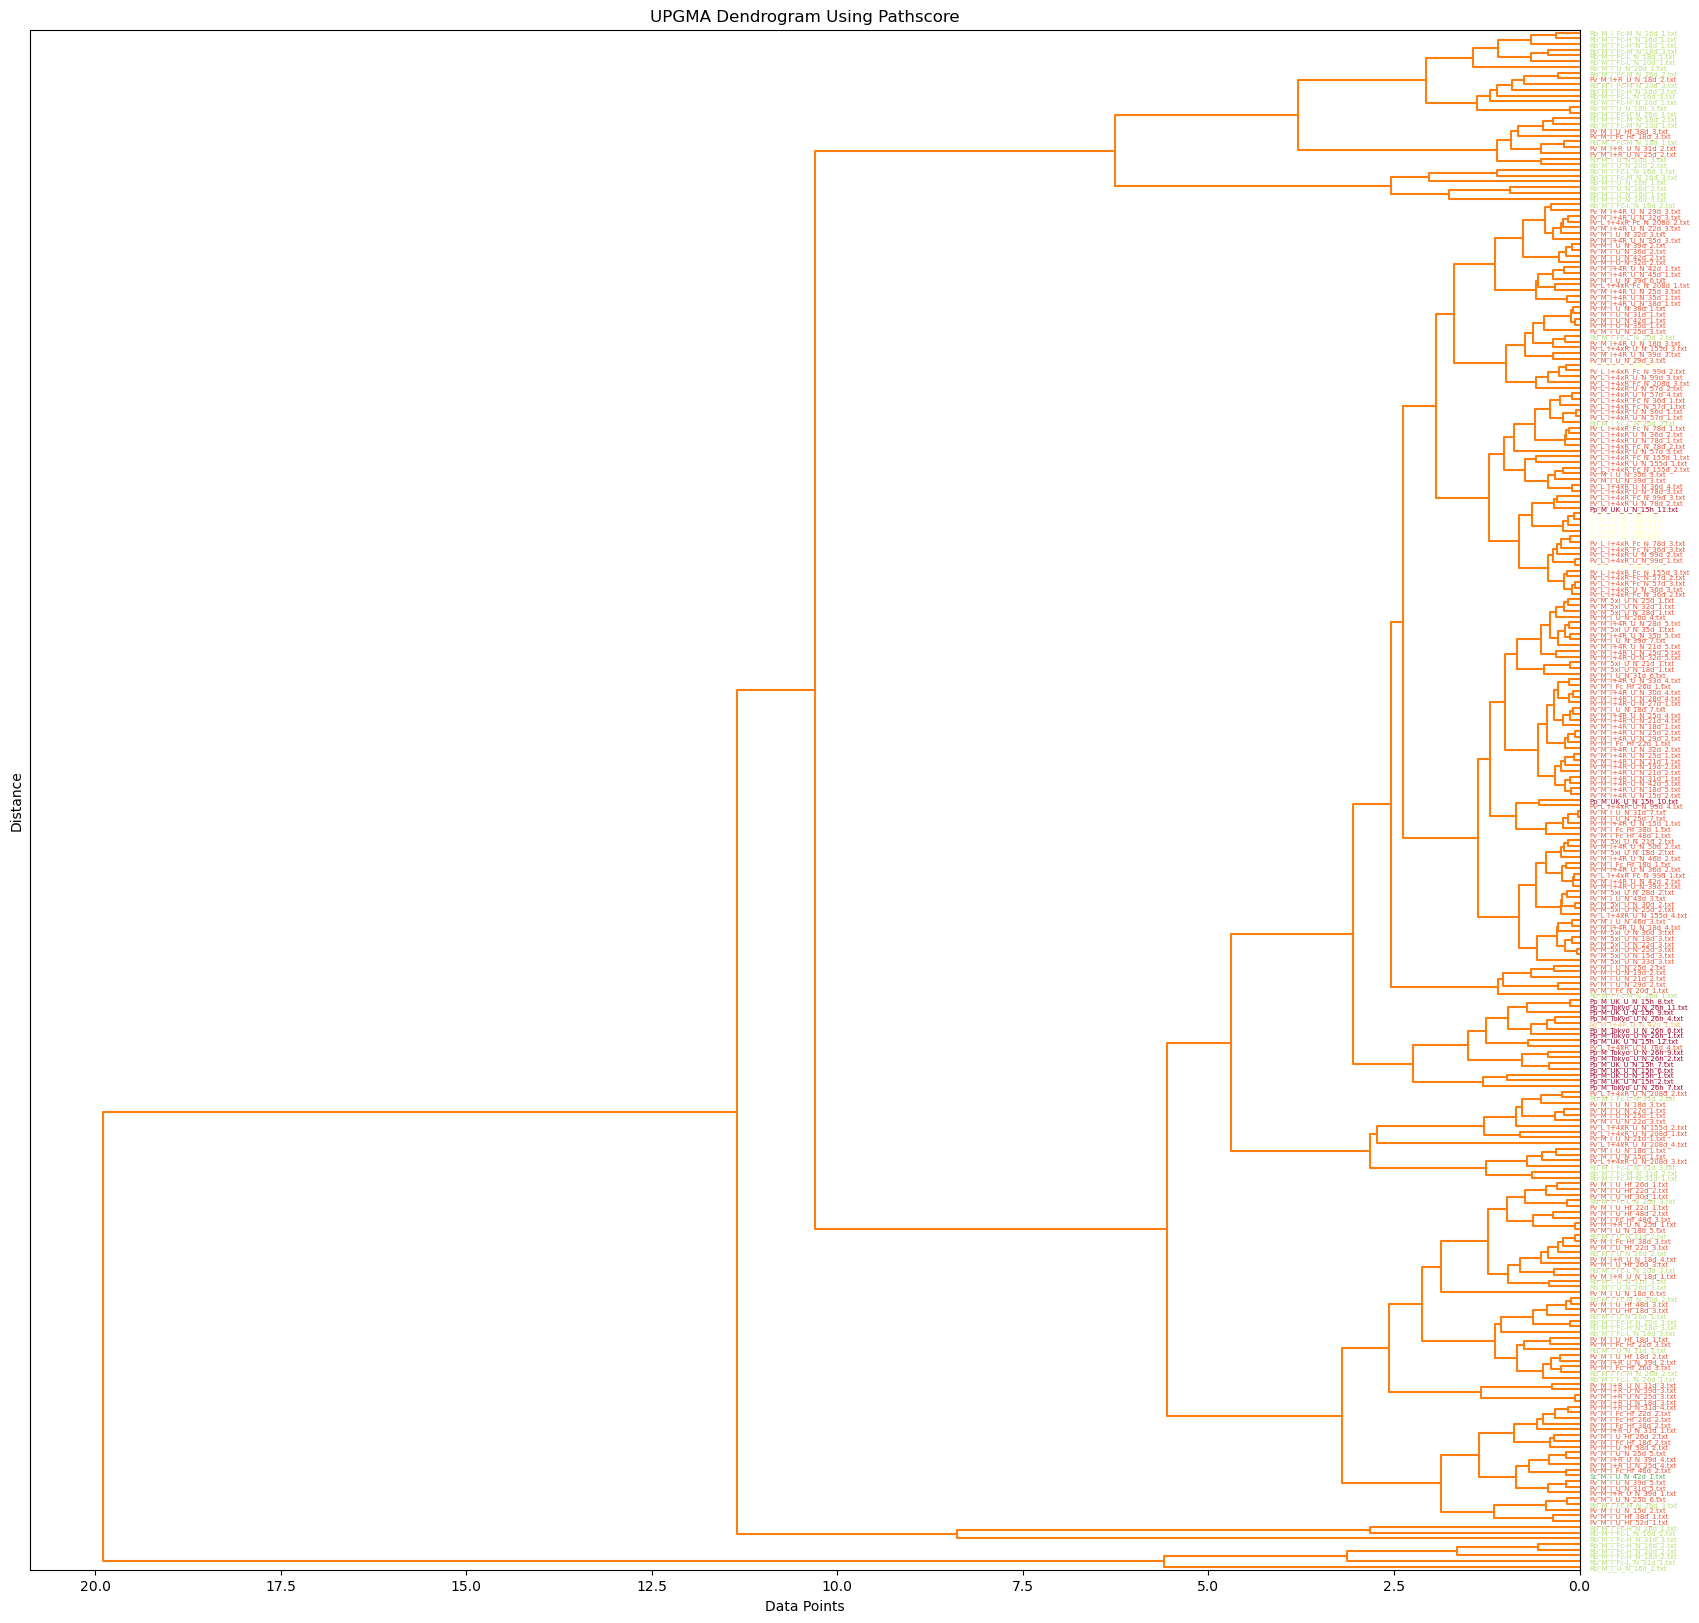

Pp: (0.6470588235294118, 0.0, 0.14901960784313725, 1.0)
Pv: (0.918954248366013, 0.3477124183006535, 0.22614379084967318, 1.0)
Ag: (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
Pi: (1.0, 1.0, 0.7490196078431373, 1.0)
Rb: (0.7176470588235295, 0.8797385620915033, 0.45882352941176474, 1.0)
Sc: (0.3006535947712421, 0.6928104575163401, 0.3633986928104576, 1.0)


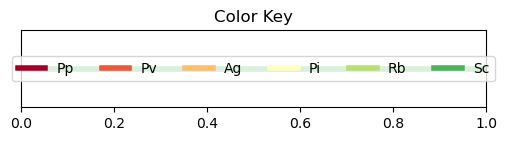

In [115]:
# graph
color_mapping = {
    'Pp': 0,
    'Pv': 1,
    'Ag': 2,
    'Pi': 3,
    'Rb': 4,
    'Sc': 5,
    'none': 6
}

def get_leaf_color(filename):
    if filename[-4:] == '.txt':
        value = filename[0:2]
        return color_mapping[value]
    else:
        return color_mapping['none']

leaf_colors = [get_leaf_color(index_name) for index_name in ps_symetric_dist_2.index]
tree = linkage(ps_symetric_dist_2, method='average',optimal_ordering=False)  # Use 'average' method for UPGMA

# Plot dendrogram
plt.figure(figsize=(20, 20))
dendrogram(tree, labels=ps_symetric_dist_2.index, leaf_rotation=0, orientation="left", color_threshold=240, above_threshold_color='grey')
plt.title('Dendrogram Using Pathscore')
plt.xlabel('Data Points')
plt.ylabel('Distance')
# plt.show()


my_palette = plt.cm.get_cmap('RdYlGn', 7)
 
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    val = get_leaf_color(lbl.get_text())
    lbl.set_color(my_palette(val))

plt.show()

# Display the colors and their corresponding labels
color_labels = ['Pp','Pv','Ag','Pi','Rb','Sc']
color_map = {my_palette(i): label for i, label in enumerate(color_labels)}
for color, label in color_map.items():
    print(f'{label}: {color}')

# Plot example colors
plt.figure(figsize=(6, 1))
for color, label in color_map.items():
    plt.plot([0, 1], [0, 0], color=color, label=label, linewidth=4)
plt.xlim(0, 1)
plt.ylim(-0.5, 0.5)
plt.yticks([])
plt.legend(loc='center', ncol=len(color_labels))
plt.title('Color Key')
plt.show()


jupyter nbconvert --to pdf --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags='{"graph"}' --output graphs.pdf Analysis.ipynb


In [165]:
####################################################################################
####################################################################################
####################################################################################
####################################################################################
#######################            ML PREDICTIONS            #######################
####################################################################################
####################################################################################
####################################################################################
####################################################################################

In [182]:
species_mapping = {
    'Pp': 0,
    'Pv': 1,
    'Ag': 2,
    'Pi': 3,
    'Rb': 4,
    'Sc': 5,
}

def get_speices_2(row):
    return species_mapping[row['file'][:2]]

# symmetric_distance_df.to_csv('distances_substrate.csv', index_label='index', header=True)
                             
ps_vmatrix = pd.read_csv('path_score_vectors.csv')
# ps_vmatrix.set_index('file', inplace=True)
# to_drop = ['Rb_M_I_Fc-M_N_31d_3.txt']  # Column name to drop
ps_vmatrix = ps_vmatrix[ps_vmatrix['file'] != 'Rb_M_I_Fc-M_N_31d_3.txt']

ps_vmatrix['species'] = ps_vmatrix.apply(get_speices_2, axis=1)
# ps_vmatrix['substrate']
ps_vmatrix

,file,C,kstd,kmean,edge_density,average_shortest_path_length,avg_betweenness_centrality,average_edge_weight,species
0,Pv_M_I+4R_U_N_27d_1.txt,0.144913,0.855159,2.785924,0.008194,0.0,0.022698,0.009950,1
1,Rb_M_I_Fc-L_N_16d_3.txt,0.136957,1.570601,3.195876,0.033290,0.0,0.053408,0.020824,4
2,Pv_M_I+4R_U_N_29d_3.txt,0.180583,0.736542,2.647619,0.012668,0.0,0.035083,0.019230,1
3,Pv_M_I_Fc_Hf_38d_2.txt,0.134267,1.056477,2.988372,0.002899,0.0,0.019169,0.003332,1
4,Pv_M_I_U_N_15d_1.txt,0.124424,0.581344,2.310078,0.018047,0.0,0.001925,0.027958,1
...,...,...,...,...,...,...,...,...,...
265,Pv_M_5xI_U_N_21d_2.txt,0.119231,0.766758,2.735043,0.004683,0.0,0.029372,0.008983,1
266,Pv_M_I_U_N_18d_6.txt,0.095137,1.262376,2.637500,0.016588,0.0,0.037684,0.025245,1
267,Pv_L_I+4xR_U_N_78d_1.txt,0.088156,0.599863,2.758539,0.003253,0.0,0.029216,0.005701,1
268,Pv_M_I_U_N_32d_3.txt,0.128259,0.694244,2.622222,0.006491,0.0,0.031155,0.010983,1


In [146]:
def get_species(row):
    index_name = row.name
    return species_mapping[index_name[:2]]

c_vmatrix = pd.read_csv('conductance_vectors.csv')
c_vmatrix.set_index('file', inplace=True)
# Apply the function to create a new column
c_vmatrix['species'] = c_vmatrix.apply(get_species, axis=1)
# symmetric_distance_df.to_csv('distances_substrate.csv', index_label='index', header=True)
c_vmatrix['species']

file
Rb_M_I_Fc-H_N_20d_1.txt     4
Pv_M_I+4R_U_N_39d_3.txt     1
Rb_M_I_U_N_18d_2.txt        4
Pv_L_I+4xR_U_N_57d_1.txt    1
Pv_M_I_U_N_31d_1.txt        1
                           ..
Pv_M_I_U_Hf_22d_2.txt       1
Pv_M_I+4R_U_N_42d_1.txt     1
Pv_M_I+R_U_N_18d_1.txt      1
Pv_M_I_U_N_18d_3.txt        1
Pv_M_5xI_U_N_22d_3.txt      1
Name: species, Length: 270, dtype: int64

In [185]:

# Step 1: Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Step 2: Prepare your dataset (replace X_train, y_train with your data)
# Assuming X_train is a 2D array of input vectors and y_train is a 1D array of corresponding target values
# Replace this with your actual dataset

selected_column_names = ['C', 'kstd', 'kmean', 'edge_density','average_shortest_path_length','avg_betweenness_centrality','average_edge_weight']
X = c_vmatrix[selected_column_names]
y = c_vmatrix['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Choose a model (in this case, Linear Regression)
model = LinearRegression()

# Step 4: Train the model
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Step 6: Make predictions (replace X_new with new data for prediction)
X_new = X  # Replace ... with the new data for prediction
c_vmatrix['predicted_species'] = model.predict(X_new)
c_vmatrix

rounded_correct_sum = (c_vmatrix['species'] == c_vmatrix['predicted_species'].round().astype(int)).sum()/c_vmatrix.shape[0]
floored_correct_sum = (c_vmatrix['species'] == np.floor(c_vmatrix['predicted_species']).astype(int)).sum()/c_vmatrix.shape[0]
print(f'rounded_correct_sum = {rounded_correct_sum}, floored_correct_sum = {floored_correct_sum}')

Mean Squared Error: 0.8791662589440585
rounded_correct_sum = 0.5962962962962963, floored_correct_sum = 0.5259259259259259


In [186]:
# Step 2: Prepare your dataset (replace X_train, y_train with your data)
# Assuming X_train is a 2D array of input vectors and y_train is a 1D array of corresponding target values
# Replace this with your actual dataset

selected_column_names = ['C', 'kstd', 'kmean', 'edge_density','average_shortest_path_length','avg_betweenness_centrality','average_edge_weight']
X = ps_vmatrix[selected_column_names]
y = ps_vmatrix['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Choose a model (in this case, Linear Regression)
model = LinearRegression()

# Step 4: Train the model
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Step 6: Make predictions (replace X_new with new data for prediction)
X_new = X  # Replace ... with the new data for prediction
ps_vmatrix['predicted_species'] = model.predict(X_new)
ps_vmatrix

rounded_correct_sum = (ps_vmatrix['species'] == ps_vmatrix['predicted_species'].round().astype(int)).sum()/ps_vmatrix.shape[0]
floored_correct_sum = (ps_vmatrix['species'] == np.floor(ps_vmatrix['predicted_species']).astype(int)).sum()/ps_vmatrix.shape[0]
print(f'rounded_correct_sum = {rounded_correct_sum}, floored_correct_sum = {floored_correct_sum}')

Mean Squared Error: 1.4289854202093506
rounded_correct_sum = 0.587360594795539, floored_correct_sum = 0.5762081784386617


In [208]:
from itertools import combinations

def predict_col(df, selected_cols, predict_col):
    X = df[selected_cols]
    y = df[predict_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Choose a model (in this case, Linear Regression)
    model = LinearRegression()

    # Step 4: Train the model
    model.fit(X_train, y_train)

    # Step 5: Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    # print("Mean Squared Error:", mse)

    # Step 6: Make predictions (replace X_new with new data for prediction)
    X_new = X  # Replace ... with the new data for prediction
    df['predicted_species'] = model.predict(X_new)

    rounded_correct_sum = (df['species'] == df['predicted_species'].round().astype(int)).sum()/df.shape[0]
    # floored_correct_sum = (df['species'] == np.floor(df['predicted_species']).astype(int)).sum()/df.shape[0]
    # print(f'rounded_correct_sum = {rounded_correct_sum}') #, floored_correct_sum = {floored_correct_sum}
    return rounded_correct_sum

def all_possible_combos(lst):
    all_combinations = []
    for r in range(1, len(lst) + 1):  # Generate combinations of different lengths
        all_combinations.extend(combinations(lst, r))
   
    all_combinations = [list(combination) for combination in all_combinations]

    return all_combinations

In [246]:
all_combos = all_possible_combos(selected_column_names)
# print(all_combos)
def predict_all_combinations(vectors, flag):
    percents = []

    for i in range(len(all_combos)):
        percent = predict_col(vectors, all_combos[i], 'species')
        percents.append(percent)

    indicies = list(range(len(all_combos)))
    combination_lengths = [len(element) for element in all_combos]
    
    if flag:
        plt.plot(indicies, percents, 'bo')  # 'bo' specifies blue circles for markers
        plt.xlabel('Index of Combination')
        plt.ylabel('Percent Accuracy')
        plt.title('Prediction Accuracy for Different Combinations of Attributes Used In Prediction')
        plt.grid(True)  # Add grid lines
        plt.show()

#         plt.plot(combination_lengths, percents, 'bo')  # 'bo' specifies blue circles for markers
#         plt.xlabel('Number of Columns Used')
#         plt.ylabel('Percent Accuracy')
#         plt.title('Prediction Accuracy for Number of Columns Used in Prediction')
#         plt.grid(True)  # Add grid lines
#         plt.show()
    
    return pd.DataFrame({'percents': percents, 'combination_lengths': combination_lengths, 'combination':all_combos})


In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full content of each column

In [231]:
sorted_c_predictions.head(10)

,percents,combination_lengths,combination
29,0.603704,3,"[C, kstd, edge_density]"
123,0.600000,6,"[C, kstd, edge_density, average_shortest_path_length, avg_betweenness_centrality, average_edge_weight]"
68,0.600000,4,"[C, kstd, edge_density, avg_betweenness_centrality]"
126,0.596296,7,"[C, kstd, kmean, edge_density, average_shortest_path_length, avg_betweenness_centrality, average_edge_weight]"
105,0.596296,5,"[C, kstd, edge_density, average_shortest_path_length, average_edge_weight]"
67,0.596296,4,"[C, kstd, edge_density, average_shortest_path_length]"
23,0.592593,2,"[edge_density, avg_betweenness_centrality]"
3,0.592593,1,[edge_density]
120,0.592593,6,"[C, kstd, kmean, edge_density, average_shortest_path_length, average_edge_weight]"
99,0.592593,5,"[C, kstd, kmean, edge_density, avg_betweenness_centrality]"


In [233]:
sorted_c_predictions.tail(10)

,percents,combination_lengths,combination
40,0.148148,3,"[C, average_shortest_path_length, avg_betweenness_centrality]"
11,0.092593,2,"[C, avg_betweenness_centrality]"
0,0.085185,1,[C]
62,0.029630,3,"[average_shortest_path_length, avg_betweenness_centrality, average_edge_weight]"
27,0.022222,2,"[avg_betweenness_centrality, average_edge_weight]"
26,0.011111,2,"[average_shortest_path_length, average_edge_weight]"
5,0.007407,1,[avg_betweenness_centrality]
25,0.007407,2,"[average_shortest_path_length, avg_betweenness_centrality]"
6,0.003704,1,[average_edge_weight]
4,0.003704,1,[average_shortest_path_length]


In [232]:
sorted_ps_predictions.head(10)

,percents,combination_lengths,combination
29,0.603704,3,"[C, kstd, edge_density]"
123,0.600000,6,"[C, kstd, edge_density, average_shortest_path_length, avg_betweenness_centrality, average_edge_weight]"
68,0.600000,4,"[C, kstd, edge_density, avg_betweenness_centrality]"
126,0.596296,7,"[C, kstd, kmean, edge_density, average_shortest_path_length, avg_betweenness_centrality, average_edge_weight]"
105,0.596296,5,"[C, kstd, edge_density, average_shortest_path_length, average_edge_weight]"
67,0.596296,4,"[C, kstd, edge_density, average_shortest_path_length]"
23,0.592593,2,"[edge_density, avg_betweenness_centrality]"
3,0.592593,1,[edge_density]
120,0.592593,6,"[C, kstd, kmean, edge_density, average_shortest_path_length, average_edge_weight]"
99,0.592593,5,"[C, kstd, kmean, edge_density, avg_betweenness_centrality]"


In [235]:
sorted_ps_predictions.tail(10)

,percents,combination_lengths,combination
40,0.148148,3,"[C, average_shortest_path_length, avg_betweenness_centrality]"
11,0.092593,2,"[C, avg_betweenness_centrality]"
0,0.085185,1,[C]
62,0.029630,3,"[average_shortest_path_length, avg_betweenness_centrality, average_edge_weight]"
27,0.022222,2,"[avg_betweenness_centrality, average_edge_weight]"
26,0.011111,2,"[average_shortest_path_length, average_edge_weight]"
5,0.007407,1,[avg_betweenness_centrality]
25,0.007407,2,"[average_shortest_path_length, avg_betweenness_centrality]"
6,0.003704,1,[average_edge_weight]
4,0.003704,1,[average_shortest_path_length]


__________________________ CONDUCTANCE PREDICTIONS __________________________


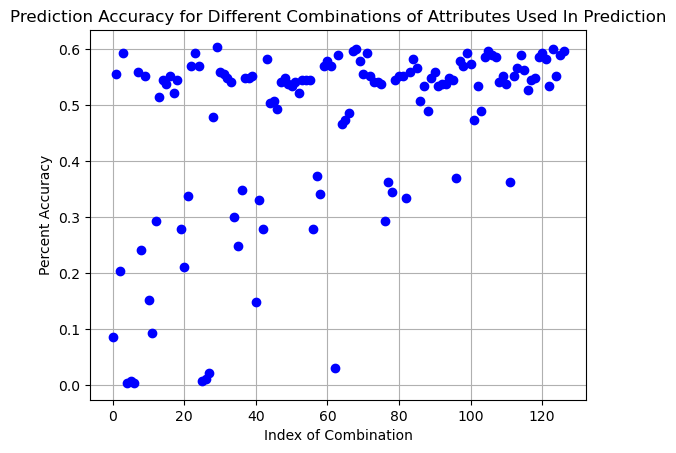

c_predictions_mean = 0.4693205016039662
c_predictions_std_dev = 0.16126925525643462



__________________________ PATH SCORE PREDICTIONS __________________________


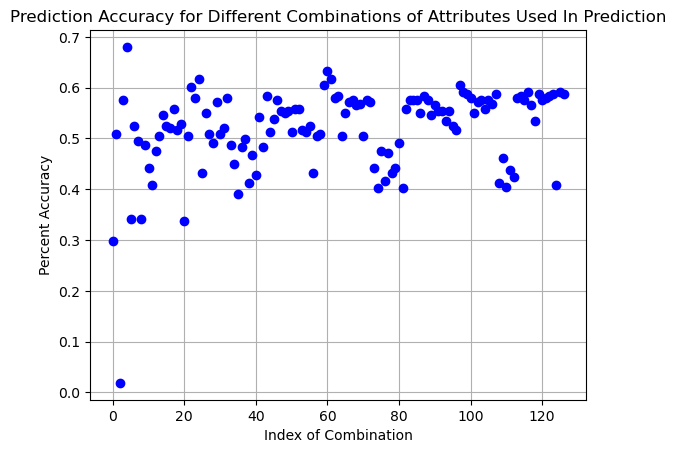

ps_predictions_mean = 0.5197143108040863
ps_predictions_std_dev = 0.08189299473278996


In [247]:
import statistics

print('__________________________ CONDUCTANCE PREDICTIONS __________________________')
c_predictions = predict_all_combinations(c_vmatrix,1)
sorted_c_predictions = c_predictions.sort_values(by='percents', ascending=False)
c_predictions_mean = np.mean(c_predictions['percents'])
c_predictions_std_dev = statistics.stdev(c_predictions['percents'])
print(f'c_predictions_mean = {c_predictions_mean}')
print(f'c_predictions_std_dev = {c_predictions_std_dev}')


print('\n\n\n__________________________ PATH SCORE PREDICTIONS __________________________')
ps_predictions = predict_all_combinations(ps_vmatrix,1)
sorted_ps_predictions = c_predictions.sort_values(by='percents', ascending=False)
ps_predictions_mean = np.mean(ps_predictions['percents'])
ps_predictions_std_dev = statistics.stdev(ps_predictions['percents'])
print(f'ps_predictions_mean = {ps_predictions_mean}')
print(f'ps_predictions_std_dev = {ps_predictions_std_dev}')